<a href="https://colab.research.google.com/github/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/blob/main/offline_open_source_data_reconstruction/tutorials/google_colab/3_GRE2D_PICS_BART_Poisson_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline Open-Source Data Reconstruction Tutorial
Reconstruct 2D GRE data with retrospective 2-fold Poisson undersampling using BART

In [1]:
#@title SENSE reconstruction with BART - installation and compilation (about 2 min 30 sec)
# Just need to run this cell once.
%%bash
# Install BART's dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone BART (delete previous version)
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart
git checkout "v0.9.00"
# Configuration
COMPILE_SPECS=" PARALLEL=1
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART
make &> /dev/null && echo ok

ok


Note: switching to 'v0.9.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 672a840f bump version


#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BART's command line interface inside an ipython jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [2]:
import sys, os
os.environ['BART_TOOLBOX_PATH'] = f"{os.getcwd()}/bart"
os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
from bart import bart
import cfl
!wget https://raw.githubusercontent.com/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main//offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

def imshow(x):
    x_array = cfl.readcfl(x)
    fig = plt.figure(figsize=(8, 5))
    plt.imshow(np.abs(x_array),cmap='gray')

def imshow_log(x):
    x_array = cfl.readcfl(x)
    fig = plt.figure(figsize=(8, 5))
    plt.imshow(np.log(np.abs(x_array)),cmap='gray')


--2025-05-05 20:08:47--  https://raw.githubusercontent.com/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main//offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main/offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat [following]
--2025-05-05 20:08:47--  https://raw.githubusercontent.com/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/main/offline_open_source_data_reconstruction/tutorials/example_data/gre2d_rawdata.mat
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 7154110 (6.8M) [applicati

Text(0.5, 1.0, 'RSS image')

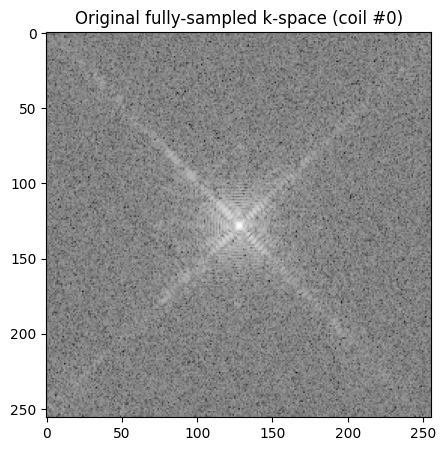

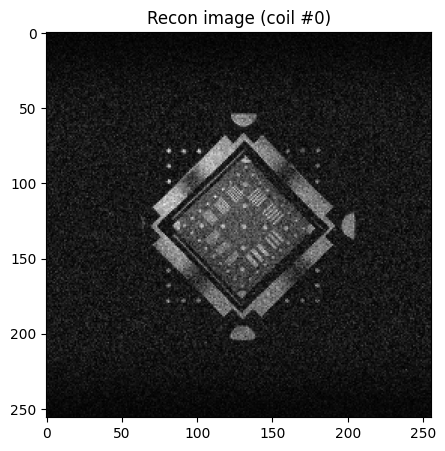

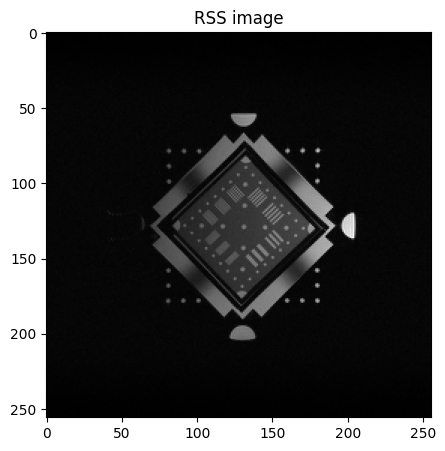

In [3]:
#@title Visualize the original fully-sampled 2D GRE k-space and recon images
# Original fully-sampled 2D GRE k-space data. Nx = Ny = 256. ncoil = 18.
gre2d_rawdata = loadmat('gre2d_rawdata.mat')
kspace = gre2d_rawdata['gre2d_rawdata']
Nx = kspace.shape[0]
Ny = kspace.shape[1]
ncoil = kspace.shape[2]
ksp = 1e6*kspace[:,:,np.newaxis,:]
ksp = cfl.writecfl('ksp', ksp)

# Reconstruct k-space using FFT
!bart fft -u -i $(bart bitmask 0 1) ksp im

# Display original fully-sampled k-space
!bart slice 3 0 ksp ksp_coil0
imshow_log('ksp_coil0')
plt.title('Original fully-sampled k-space (coil #0)')

# Slice out one coil-image of the reconstructed k-space phantom and display.
!bart slice 3 0 im im_coil0
imshow('im_coil0')
plt.title('Recon image (coil #0)')

# Combine all coils (Root-Sum-of-Squares)
!bart rss $(bart bitmask 3) im im_rss
imshow('im_rss')
plt.title('RSS image')

points: 13591, grid size: 256x256x(pi/4) = 51471 (R = 3.787201)
Poisson-disc sampling pattern
Type: complex float
Dimensions: 16
AoD:	256	256	1	18	1	1	1	1	1	1	1	1	1	1	1	1


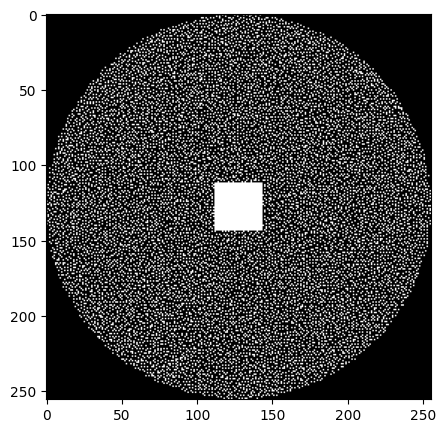

In [4]:
#@title Perform retrospecive undersampling

# Create Poisson-Disc undersampling pattern

# 2x2-fold in-plane acceleration. Auto-calibration region: 32x32
!bart poisson -Y 256 -y 2 -Z 256 -z 2 -C 32 -e poisson

# Reshape into required dimensions to match the k-space
!bart squeeze poisson poisson

# Show pattern
print("Poisson-disc sampling pattern")
imshow('poisson')

# generate undersampled kspace and reference kspace
!bart fmac ksp poisson ksp_us
!bart show -m ksp_us

##Plot and observe the under-sampled k-space data and recon images
Now we will look at the under-sampled k-space data.

<ipython-input-5-c2e1444e4c39>:6: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(ksp_us_array[:,:,:,i*6+index])),cmap='gray')


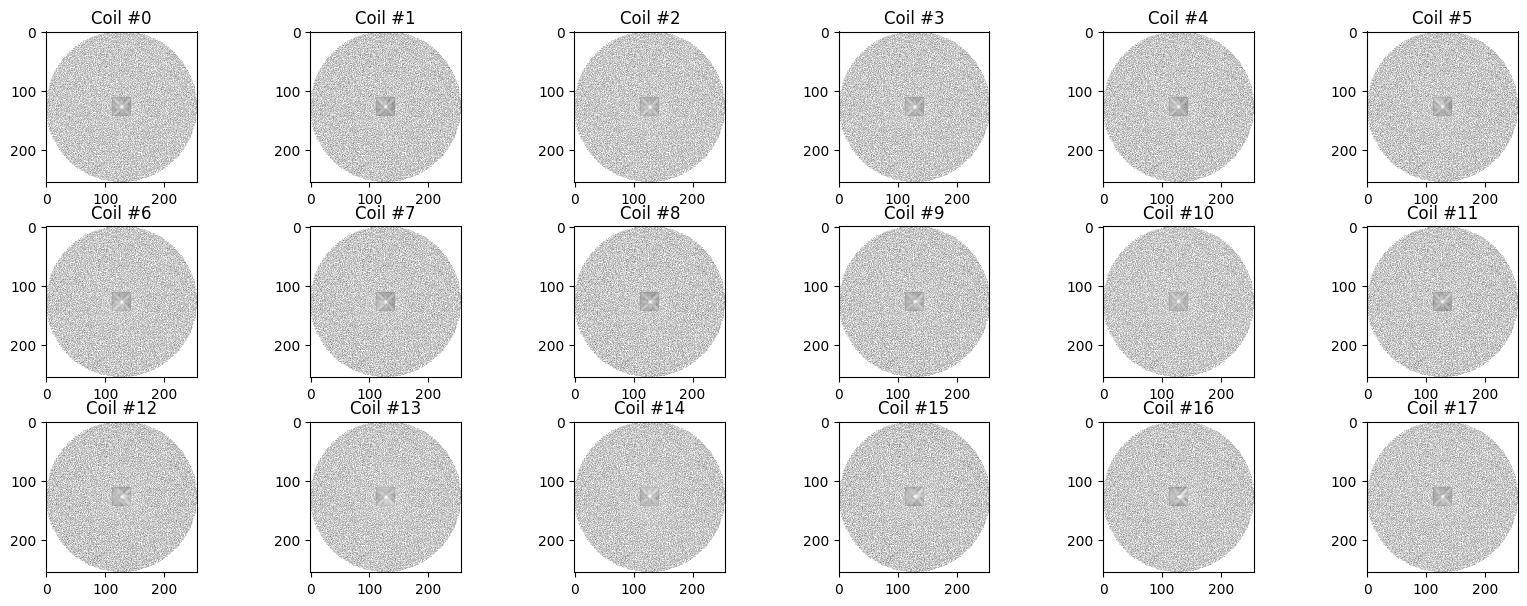

In [5]:
fig, axes = plt.subplots(3, 6, figsize=(16, 6))
ksp_us_array = cfl.readcfl('ksp_us')
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(3):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.log(np.abs(ksp_us_array[:,:,:,i*6+index])),cmap='gray')
        ax.set_title('Coil #{}'.format(i*6 + index))

Visualize the under-sampled data in the image domain.    
Perform a linear Fourier reconstruction of the under-sampled k-space data.

In [6]:
# take IFFT of the under-sampled k-space data
!bart fft -u -i $(bart bitmask 0 1) ksp_us cimg_us
###
!bart show -m cimg_us

Type: complex float
Dimensions: 16
AoD:	256	256	1	18	1	1	1	1	1	1	1	1	1	1	1	1


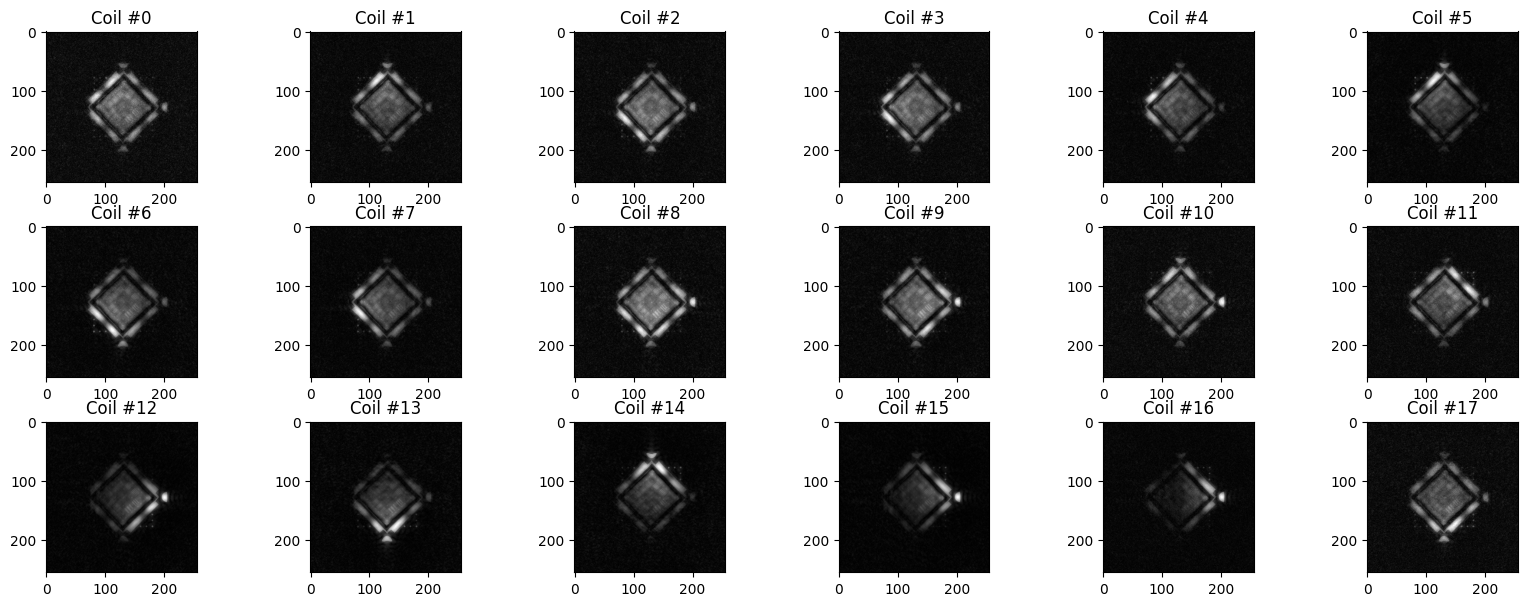

In [7]:
# visualize the undersampled coil images
cimg_us_array = cfl.readcfl('cimg_us')
fig, axes = plt.subplots(3, 6, figsize=(16, 6))
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(3):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.abs(cimg_us_array[:,:,:,i*6+index]), cmap='gray')
        ax.set_title('Coil #{}'.format(i*6 + index))

Perform an RSS reconstruction of the undersampled coil images and plot it. You can observe the blurred image of the phantom.

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Text(0.5, 1.0, 'Undersampled image (root of sum of squares)')

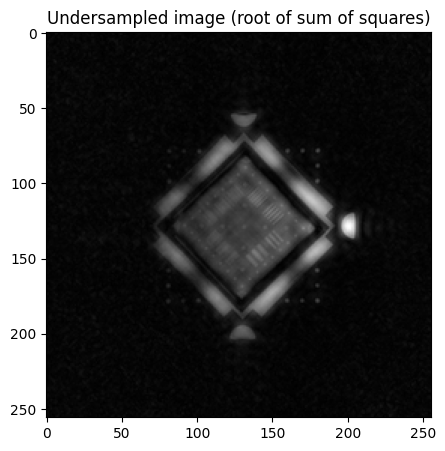

In [8]:
!bart rss $(bart bitmask 3) cimg_us rss_us
!bart show -m rss_us
# visualize the undersampled RSS image
imshow('rss_us')
plt.title('Undersampled image (root of sum of squares)')

##Calculate PICS scale factor
The parallel imaging and compressed sensing, `bart pics` command typically scales the k-space data so that the RSS image has maximum value close to one. This is so that the regularization factor is more consistent across different input datasets.

The scale factor is chosen based on the RSS reconstruction of a fully sampled auto-calibration region in the data:

scale_factor = np.percentile(abs(rss_acs), 99)
where `np.percentile` selects the 99th percentile and `rss_acs` is the RSS reconstruction.

When the input data do not contain a fully sampled calibration region, the `pics` command will not be able to automatically compute the scale factor and it will default to 1.0. Therefore, it is useful to manually calculate the scale factor and pass it to the `pics` command through the `-w` option.

In [9]:
# get the scale factor from the reference data
rss_us_array = cfl.readcfl('rss_us')
scale_factor = np.percentile(abs(rss_us_array), 99)
print('Scale factor: {:.5f}'.format(scale_factor))

Scale factor: 84.95004


##Coil Compression
Before reconstucting, we will coil-compress the coils using the Software Coil Compression method.         
To see more information about any of these commands use `!bart cc -h` in a new cell.

Done.
ksp_cc_us:
Type: complex float
Dimensions: 16
AoD:	256	256	1	8	1	1	1	1	1	1	1	1	1	1	1	1


<ipython-input-10-b1bc2a946f0d>:9: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(ksp_us_cc_array[:,:,:,i*4+index])),cmap='gray')


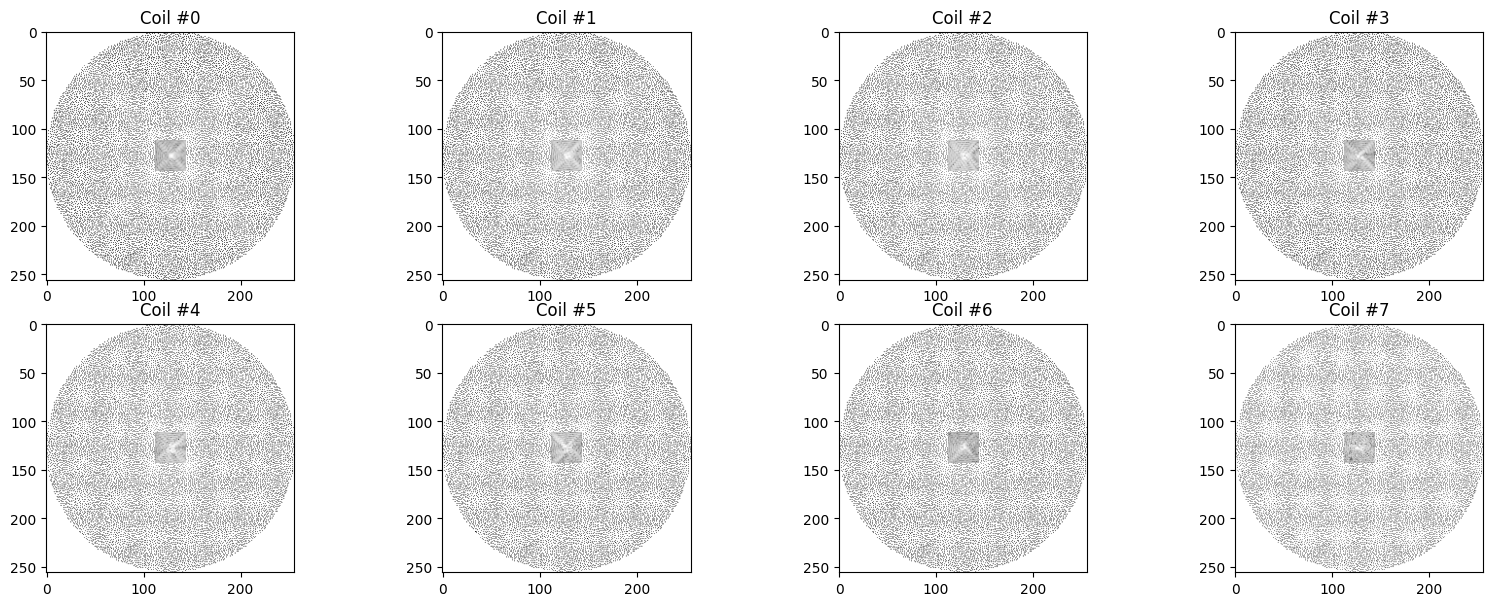

In [10]:
# Compress kspace to 8 coils
!bart cc -p 8 ksp_us ksp_us_cc

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
ksp_us_cc_array = cfl.readcfl('ksp_us_cc')
plt.tight_layout() # This automatically puts space between plots and make it tidy
for i in range(2):
    for ax, index in zip(axes[i], range(ncoil)):
        ax.imshow(np.log(np.abs(ksp_us_cc_array[:,:,:,i*4+index])),cmap='gray')
        ax.set_title('Coil #{}'.format(i*4 + index))
print('ksp_cc_us:')
!bart show -m ksp_us_cc

##Coil sensitvity map calibration
Use `bart ecalib` command to estimate the coil sensitivities from the coil-compressed reference scan k-space data and plot the coil sensitivity maps.   
You can use the `-a` parameter to automatically estimate the ESPIRiT parameters. Call the output `coil_sens`.      
See more information: `!bart ecalib -h`

In [11]:
# Compute sensitivity maps using ESPIRiT (constrained to a single map)
# change the DEBUG_LEVEL for this command to reduce the output
!DEBUG_LEVEL=1 bart ecalib -a -m 1 ksp_us_cc coil_sens
!bart show -m coil_sens

Done.
Type: complex float
Dimensions: 16
AoD:	256	256	1	8	1	1	1	1	1	1	1	1	1	1	1	1


Text(0.5, 1.0, 'Estimated sensitivity maps with auto-ESPIRiT (8 virtual coils)')

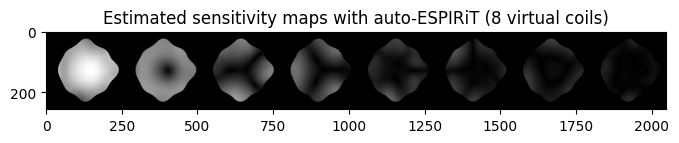

In [12]:
# visualize the estimated coil sensitivities
!bart reshape $(bart bitmask 1 3) 2048 1 coil_sens coil_sens_flat
imshow('coil_sens_flat')
plt.title('Estimated sensitivity maps with auto-ESPIRiT (8 virtual coils)')

##Parallel-imaging compressed-sensing reconstruction (PICS)
Reconstruct the coil-compressed data using the `bart pics` command. First, run the help command and observe which flags you will require for regularization options, manual scaling/re-scaling of the data, and input order. We recommend using l2 regularization.

Plot the reconstructed image and observe that the aliasing is removed and you can see a high-resolution image of the phantom.        
see more information: `!bart pics -h`

Text(0.5, 1.0, 'Reconstruction with l2 regularization')

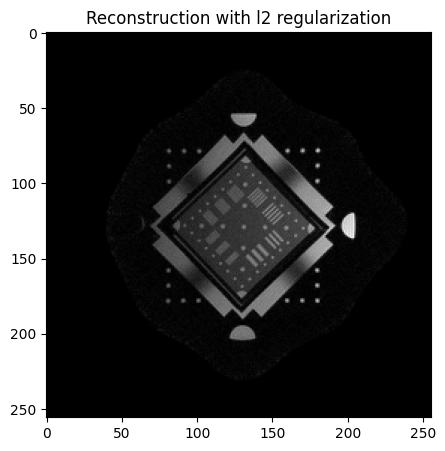

In [13]:
# PICS reconstruction using l2 regularization
!DEBUG_LEVEL=1 bart pics -w 90 -R Q:1e-4 -S ksp_us_cc coil_sens im_us_cc_l2

# Show reconstruction using l2 regularization
imshow('im_us_cc_l2')
plt.title('Reconstruction with l2 regularization')

we can also run `pics` using
l1-norm regularization in a wavelet domain, where the wavelet sparsity transform is applied along the spatial (i.e., 1st, 2nd) dimensions.
`W:$(bart bitmask 1 2):0:<l1wav_reg>` -> wavelet regularization over dims 0 and 1 (typically image dimensions).     
`-S` -> SENSE model (using sensitivity maps)

Size: 65536 Samples: 13591 Acc: 4.82
l1-wavelet regularization: 0.000010
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 0.944019


Text(0.5, 1.0, 'Reconstruction using L1 Wavelet Regularization')

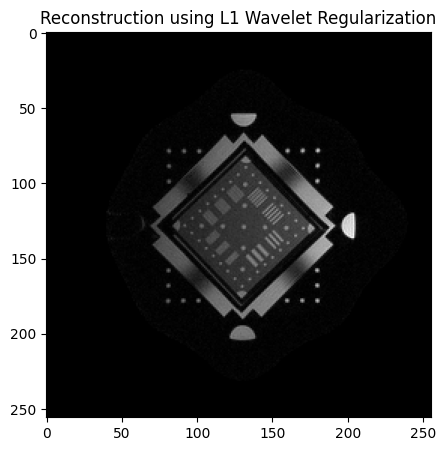

In [14]:
l1wav_reg=1e-5

# Parallel Imaging Compressed Sensing reconstruction using WAVELET sparsity regularization
!bart pics -w 90 -S -R W:$(bart bitmask 0 1):0:$l1wav_reg ksp_us_cc coil_sens ksp_us_cc_wavelet

# Show Wavelet reconstructions
imshow('ksp_us_cc_wavelet')
plt.title("Reconstruction using L1 Wavelet Regularization")